# Import Library

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Load data

In [4]:
df = pd.read_excel("../dataset/data_pip_cleaned.xlsx")
df.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS,Status
0,Jalan kaki,Wirausaha,4213001,1,Tidak,Tidak,Tidak Layak
1,Sepeda motor,Lainnya,3249958,Lebih dari 3,Tidak,Tidak,Layak
2,Jalan kaki,Peternak,4166323,2,Tidak,Tidak,Tidak Layak
3,Jalan kaki,Lainnya,3261966,2,Tidak,Tidak,Tidak Layak
4,Sepeda motor,Wirausaha,3254943,Lebih dari 3,Tidak,Tidak,Layak


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Alat Transportasi      1000 non-null   object
 1   Pekerjaan Orang Tua    1000 non-null   object
 2   Penghasilan Orang Tua  1000 non-null   int64 
 3   Jumlah Tanggungan      1000 non-null   object
 4   Pemilik KIP            1000 non-null   object
 5   Pemilik KPS            1000 non-null   object
 6   Status                 1000 non-null   object
dtypes: int64(1), object(6)
memory usage: 54.8+ KB


# Preprocessing Data

In [6]:
# pilih otomatis kolom numerik
num_columns = df.select_dtypes(include=[np.number]).columns

# standarkan fitur numerik
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])
df.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS,Status
0,Jalan kaki,Wirausaha,1.179092,1,Tidak,Tidak,Tidak Layak
1,Sepeda motor,Lainnya,0.417046,Lebih dari 3,Tidak,Tidak,Layak
2,Jalan kaki,Peternak,1.142156,2,Tidak,Tidak,Tidak Layak
3,Jalan kaki,Lainnya,0.426548,2,Tidak,Tidak,Tidak Layak
4,Sepeda motor,Wirausaha,0.420991,Lebih dari 3,Tidak,Tidak,Layak


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# pilih tipe kategorical
cat_columns = df.select_dtypes(include=['object']).columns

# encode categorical variables
for col in cat_columns:
    df[col] = le.fit_transform(df[col])

df.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS,Status
0,0,4,1.179092,0,0,0,1
1,1,1,0.417046,3,0,0,0
2,0,3,1.142156,1,0,0,1
3,0,1,0.426548,1,0,0,1
4,1,4,0.420991,3,0,0,0


# Split data

In [8]:
# Split data
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Status'])
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# prrint shape
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (800, 6)
X_test shape: (200, 6)
y_train shape: (800,)
y_test shape: (200,)


# Modeling

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Pastikan X_train dan X_test adalah numpy array
X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.values
X_test_np = X_test if isinstance(X_test, np.ndarray) else X_test.values

# Reshape untuk Conv1D
X_train_cnn = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_cnn = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)


model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'),
    # Kurangi MaxPooling atau hilangkan layer pooling berikut supaya panjang sequence tetap valid
    # MaxPooling1D(pool_size=2),  # <--- dihilangkan
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 6, 64)             192       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 3, 32)             4128      
                                                                 
 flatten_2 (Flatten)         (None, 96)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                3104      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                      

# Training Model

In [14]:
# Training model CNN
history = model_cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
20/20 [==============================] - 1s 12ms/step - loss: 0.6853 - accuracy: 0.5250 - val_loss: 0.6558 - val_accuracy: 0.5875
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5938 - val_loss: 0.6531 - val_accuracy: 0.6062
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6172 - val_loss: 0.6493 - val_accuracy: 0.6000
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.6478 - accuracy: 0.6359 - val_loss: 0.6419 - val_accuracy: 0.5875
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6328 - val_loss: 0.6392 - val_accuracy: 0.5875
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6609 - val_loss: 0.6502 - val_accuracy: 0.6062
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6547 - val_loss: 0.6364 - val_accuracy: 0.5750
Epoch 8/50
20/20 [=

In [15]:
# Evaluasi
loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

7/7 [==============================] - 0s 1ms/step - loss: 0.6754 - accuracy: 0.6350
Test Accuracy: 0.6350


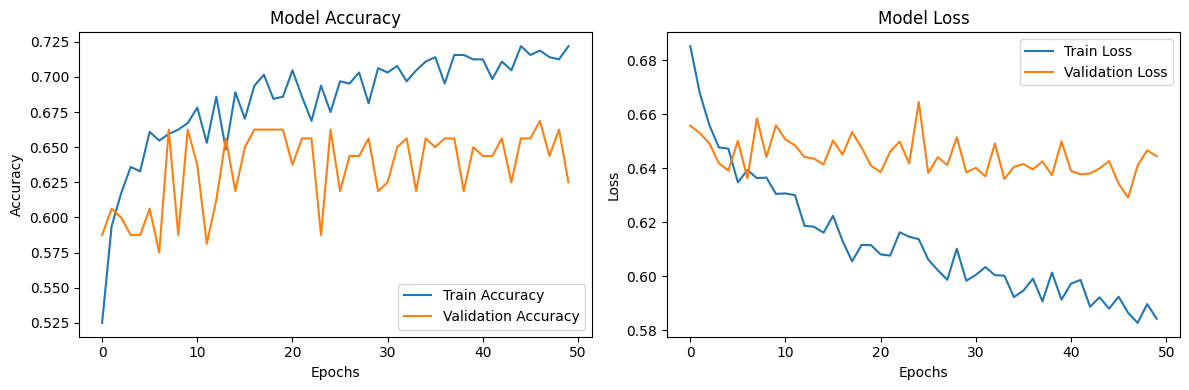

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Evaluate model
loss, accuracy = model_cnn.evaluate(X_test, y_test)
loss_train, accuracy_train = model_cnn.evaluate(X_train, y_train)

print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")
print("=====================================")
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Loss: {loss_train}")




25/25 [==============================] - 0s 1ms/step - loss: 0.5921 - accuracy: 0.6988
Test Accuracy: 0.6349999904632568
Test Loss: 0.6754395961761475
Train Accuracy: 0.6987500190734863
Train Loss: 0.5921329855918884


7/7 [==============================] - 0s 3ms/step


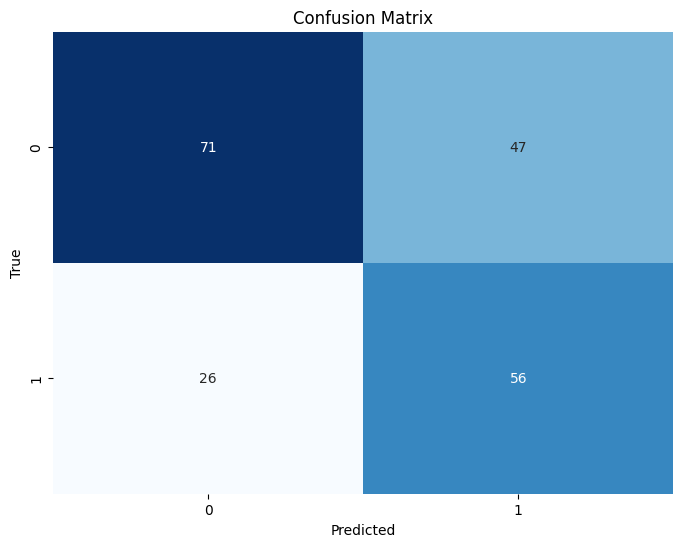

              precision    recall  f1-score   support

 Tidak Layak       0.73      0.60      0.66       118
       Layak       0.54      0.68      0.61        82

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.63       200
weighted avg       0.65      0.64      0.64       200



In [21]:
# Predict
y_pred = model_cnn.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Tidak Layak', 'Layak']))